In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# Python library imports: numpy, random, sklearn, pandas, etc

# import warnings
# warnings.filterwarnings('ignore')

# import sys
# import random
# import numpy as np

# from sklearn import linear_model, cross_validation, metrics, svm
# from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import StandardScaler

# import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline

In [2]:
import sys
import os

import numpy as np
from pyspark import SparkConf, SparkContext

from pyspark.mllib.linalg import Vectors
#from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint

from pyspark.sql import Row

In [3]:
from pyspark.mllib.classification import LogisticRegressionWithSGD, LogisticRegressionWithLBFGS
#from pyspark.mllib.regression import LinearRegressionWithSGD, LinearRegressionModel
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.param import Param, Params

In [4]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils

In [5]:
from pyspark.mllib.classification import SVMWithSGD, SVMModel

In [6]:
data_raw = sc.textFile("D:\\lectures\\bdpj\docs 2\\kaggle samples\\5_Walmart shopping trip\\sample_walmart.csv")

In [8]:
data_raw = data_raw.map(lambda x: x.replace('"CANDY, TOBACCO, COOKIES"', 'CANDY_TOBACCO_COOKIES'))

In [9]:
data_raw.take(1)

[u'TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber']

In [10]:
data_parsed = data_raw.map(lambda line: line.split(","))

In [11]:
header = data_parsed.first()
data_parsed = data_parsed.filter(lambda line:line != header)

In [12]:
data_parsed.take(1)

[[u'999',
  u'5',
  u'Friday',
  u'68113152929',
  u'-1',
  u'FINANCIAL SERVICES',
  u'1000']]

In [13]:
df = data_parsed.map(lambda line: Row(TripType = line[0], VisitNumber = line[1], Weekday =line[2], Upc=line[3], ScanCount=line[4], DepartmentDescription=line[5], FinelineNumber=line[6])).toDF()

In [14]:
df.take(1)

[Row(DepartmentDescription=u'FINANCIAL SERVICES', FinelineNumber=u'1000', ScanCount=u'-1', TripType=u'999', Upc=u'68113152929', VisitNumber=u'5', Weekday=u'Friday')]

In [15]:
df.show(5)

+---------------------+--------------+---------+--------+-----------+-----------+-------+
|DepartmentDescription|FinelineNumber|ScanCount|TripType|        Upc|VisitNumber|Weekday|
+---------------------+--------------+---------+--------+-----------+-----------+-------+
|   FINANCIAL SERVICES|          1000|       -1|     999|68113152929|          5| Friday|
|                SHOES|          8931|        1|      30|60538815980|          7| Friday|
|        PERSONAL CARE|          4504|        1|      30| 7410811099|          7| Friday|
| PAINT AND ACCESSO...|          3565|        2|      26| 2238403510|          8| Friday|
| PAINT AND ACCESSO...|          1017|        2|      26| 2006613744|          8| Friday|
+---------------------+--------------+---------+--------+-----------+-----------+-------+
only showing top 5 rows



In [16]:
df.first()

Row(DepartmentDescription=u'FINANCIAL SERVICES', FinelineNumber=u'1000', ScanCount=u'-1', TripType=u'999', Upc=u'68113152929', VisitNumber=u'5', Weekday=u'Friday')

In [115]:
pandata = df.toPandas()

In [19]:
pandata.head()

,DepartmentDescription,FinelineNumber,ScanCount,TripType,Upc,VisitNumber,Weekday
0,FINANCIAL SERVICES,1000,-1,999,68113152929,5,Friday
1,SHOES,8931,1,30,60538815980,7,Friday
2,PERSONAL CARE,4504,1,30,7410811099,7,Friday
3,PAINT AND ACCESSORIES,3565,2,26,2238403510,8,Friday
4,PAINT AND ACCESSORIES,1017,2,26,2006613744,8,Friday


In [23]:
col_dept = df.select('DepartmentDescription').distinct().sort(df.DepartmentDescription.asc())
col_dept_sum = col_dept.count()
col_dept.show(col_dept_sum)
# for row in col_dept.collect():
#     print row

# sqlContext.sql("SELECT DISTINCT DepartmentDescription FROM df")

+---------------------+
|DepartmentDescription|
+---------------------+
|          ACCESSORIES|
|           AUTOMOTIVE|
|               BAKERY|
|               BEAUTY|
|  BOOKS AND MAGAZINES|
|            BOYS WEAR|
| CANDY_TOBACCO_COO...|
|          CELEBRATION|
|           COMM BREAD|
|        COOK AND DINE|
|                DAIRY|
|          DSD GROCERY|
|   FABRICS AND CRAFTS|
|   FINANCIAL SERVICES|
|         FROZEN FOODS|
|    GROCERY DRY GOODS|
|             HARDWARE|
|      HOME MANAGEMENT|
| HOUSEHOLD CHEMICA...|
| HOUSEHOLD PAPER G...|
|  IMPULSE MERCHANDISE|
| INFANT CONSUMABLE...|
| JEWELRY AND SUNGL...|
|           LADIESWEAR|
|      LAWN AND GARDEN|
| MEAT - FRESH & FR...|
|            MENS WEAR|
|                 NULL|
|      OFFICE SUPPLIES|
| PAINT AND ACCESSO...|
|        PERSONAL CARE|
|    PETS AND SUPPLIES|
|         PHARMACY OTC|
|      PRE PACKED DELI|
|              PRODUCE|
|              SEAFOOD|
|         SERVICE DELI|
|        SHEER HOSIERY|
|               

In [24]:
df.registerTempTable("dtable")

In [25]:
dept = sqlContext.sql("SELECT DepartmentDescription, COUNT(*) as c FROM dtable GROUP BY DepartmentDescription")
dept_show = dept.show()
dept_collect = dept.collect()

+---------------------+---+
|DepartmentDescription|  c|
+---------------------+---+
|            BOYS WEAR|  2|
|         FROZEN FOODS|  9|
|         PHARMACY OTC| 16|
|              PRODUCE| 23|
| PAINT AND ACCESSO...| 16|
|           COMM BREAD|  8|
|               BAKERY|  5|
|          CELEBRATION|  5|
|         SERVICE DELI|  3|
|                SHOES|  3|
|               BEAUTY|  3|
|  IMPULSE MERCHANDISE| 19|
|        PERSONAL CARE| 21|
|             HARDWARE|  7|
|   FINANCIAL SERVICES|  5|
|      OFFICE SUPPLIES|  1|
|      PRE PACKED DELI|  2|
| CANDY_TOBACCO_COO...| 13|
|   FABRICS AND CRAFTS|  9|
| MEAT - FRESH & FR...|  1|
+---------------------+---+
only showing top 20 rows



In [26]:
dept_collect

[Row(DepartmentDescription=u'BOYS WEAR', c=2),
 Row(DepartmentDescription=u'FROZEN FOODS', c=9),
 Row(DepartmentDescription=u'PHARMACY OTC', c=16),
 Row(DepartmentDescription=u'PRODUCE', c=23),
 Row(DepartmentDescription=u'PAINT AND ACCESSORIES', c=16),
 Row(DepartmentDescription=u'COMM BREAD', c=8),
 Row(DepartmentDescription=u'BAKERY', c=5),
 Row(DepartmentDescription=u'CELEBRATION', c=5),
 Row(DepartmentDescription=u'SERVICE DELI', c=3),
 Row(DepartmentDescription=u'SHOES', c=3),
 Row(DepartmentDescription=u'BEAUTY', c=3),
 Row(DepartmentDescription=u'IMPULSE MERCHANDISE', c=19),
 Row(DepartmentDescription=u'PERSONAL CARE', c=21),
 Row(DepartmentDescription=u'HARDWARE', c=7),
 Row(DepartmentDescription=u'FINANCIAL SERVICES', c=5),
 Row(DepartmentDescription=u'OFFICE SUPPLIES', c=1),
 Row(DepartmentDescription=u'PRE PACKED DELI', c=2),
 Row(DepartmentDescription=u'CANDY_TOBACCO_COOKIES', c=13),
 Row(DepartmentDescription=u'FABRICS AND CRAFTS', c=9),
 Row(DepartmentDescription=u'MEAT 

In [35]:
dept_count = map(lambda e: e.c, dept_collect)
dept_count

[2,
 9,
 16,
 23,
 16,
 8,
 5,
 5,
 3,
 3,
 3,
 19,
 21,
 7,
 5,
 1,
 2,
 13,
 9,
 1,
 1,
 2,
 1,
 2,
 6,
 1,
 2,
 5,
 8,
 17,
 2,
 3,
 4,
 31,
 1,
 2,
 1,
 38,
 2]

In [34]:
dept_name = map(lambda e: "%s (%d)" % (e.DepartmentDescription, e.c), dept_collect)
# dept_count = map(lambda e: e.DepartmentDescription, dept_collect)
dept_name

[u'BOYS WEAR (2)',
 u'FROZEN FOODS (9)',
 u'PHARMACY OTC (16)',
 u'PRODUCE (23)',
 u'PAINT AND ACCESSORIES (16)',
 u'COMM BREAD (8)',
 u'BAKERY (5)',
 u'CELEBRATION (5)',
 u'SERVICE DELI (3)',
 u'SHOES (3)',
 u'BEAUTY (3)',
 u'IMPULSE MERCHANDISE (19)',
 u'PERSONAL CARE (21)',
 u'HARDWARE (7)',
 u'FINANCIAL SERVICES (5)',
 u'OFFICE SUPPLIES (1)',
 u'PRE PACKED DELI (2)',
 u'CANDY_TOBACCO_COOKIES (13)',
 u'FABRICS AND CRAFTS (9)',
 u'MEAT - FRESH & FROZEN (1)',
 u'NULL (1)',
 u'HOME MANAGEMENT (2)',
 u'ACCESSORIES (1)',
 u'BOOKS AND MAGAZINES (2)',
 u'MENS WEAR (6)',
 u'JEWELRY AND SUNGLASSES (1)',
 u'AUTOMOTIVE (2)',
 u'HOUSEHOLD CHEMICALS/SUPP (5)',
 u'HOUSEHOLD PAPER GOODS (8)',
 u'DAIRY (17)',
 u'COOK AND DINE (2)',
 u'INFANT CONSUMABLE HARDLINES (3)',
 u'LADIESWEAR (4)',
 u'GROCERY DRY GOODS (31)',
 u'LAWN AND GARDEN (1)',
 u'SHEER HOSIERY (2)',
 u'SEAFOOD (1)',
 u'DSD GROCERY (38)',
 u'PETS AND SUPPLIES (2)']

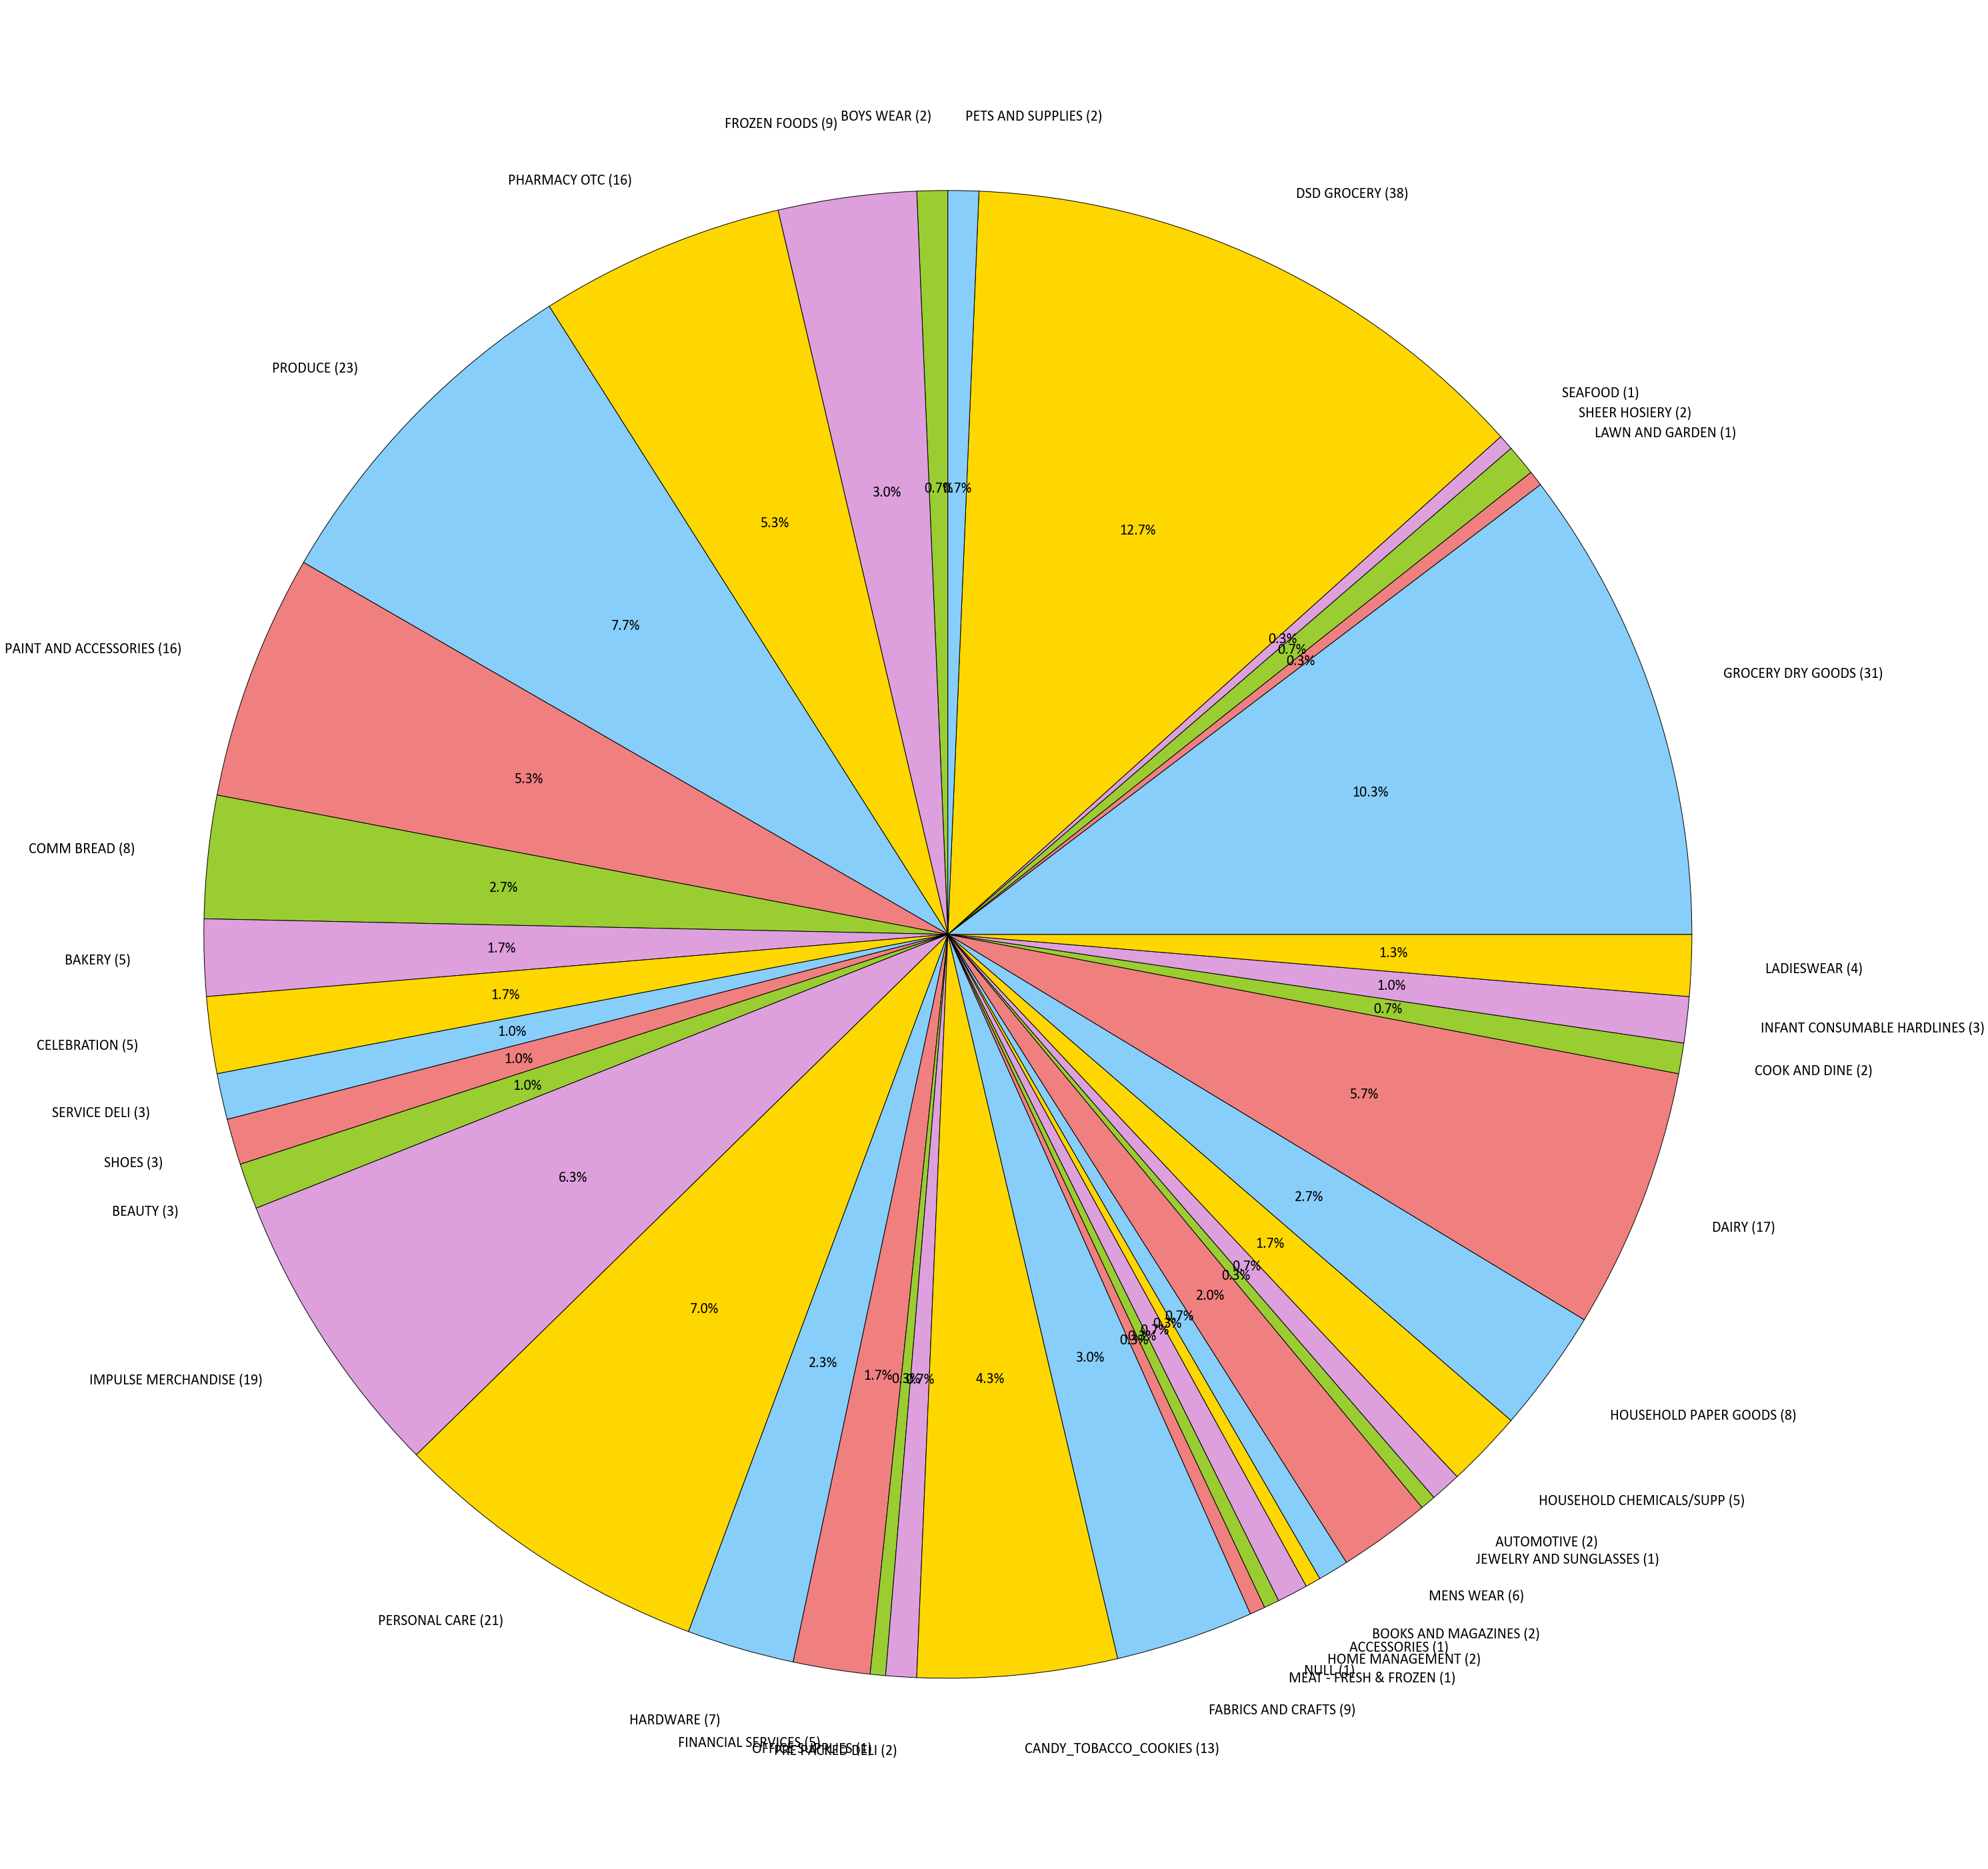

In [53]:
# font = {'family' : 'Calibri',
#         'weight' : 'regular',
#         'size'   : 22}
# plt.rc('font', **font)

plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(50,50), dpi=1600) 
# count = map(lambda e: e.c, summary)
# dept = map(lambda e: "%s (%d)" % (e.DepartmentDescription, e.DeptCount), summary)
colors = ['yellowgreen', 'plum', 'gold', 'lightskyblue', 'lightcoral']
plt.pie(dept_count, labels=dept_name, colors=colors, startangle=90, autopct="%1.1f%%")
# plt.axis('equal')
plt.show()

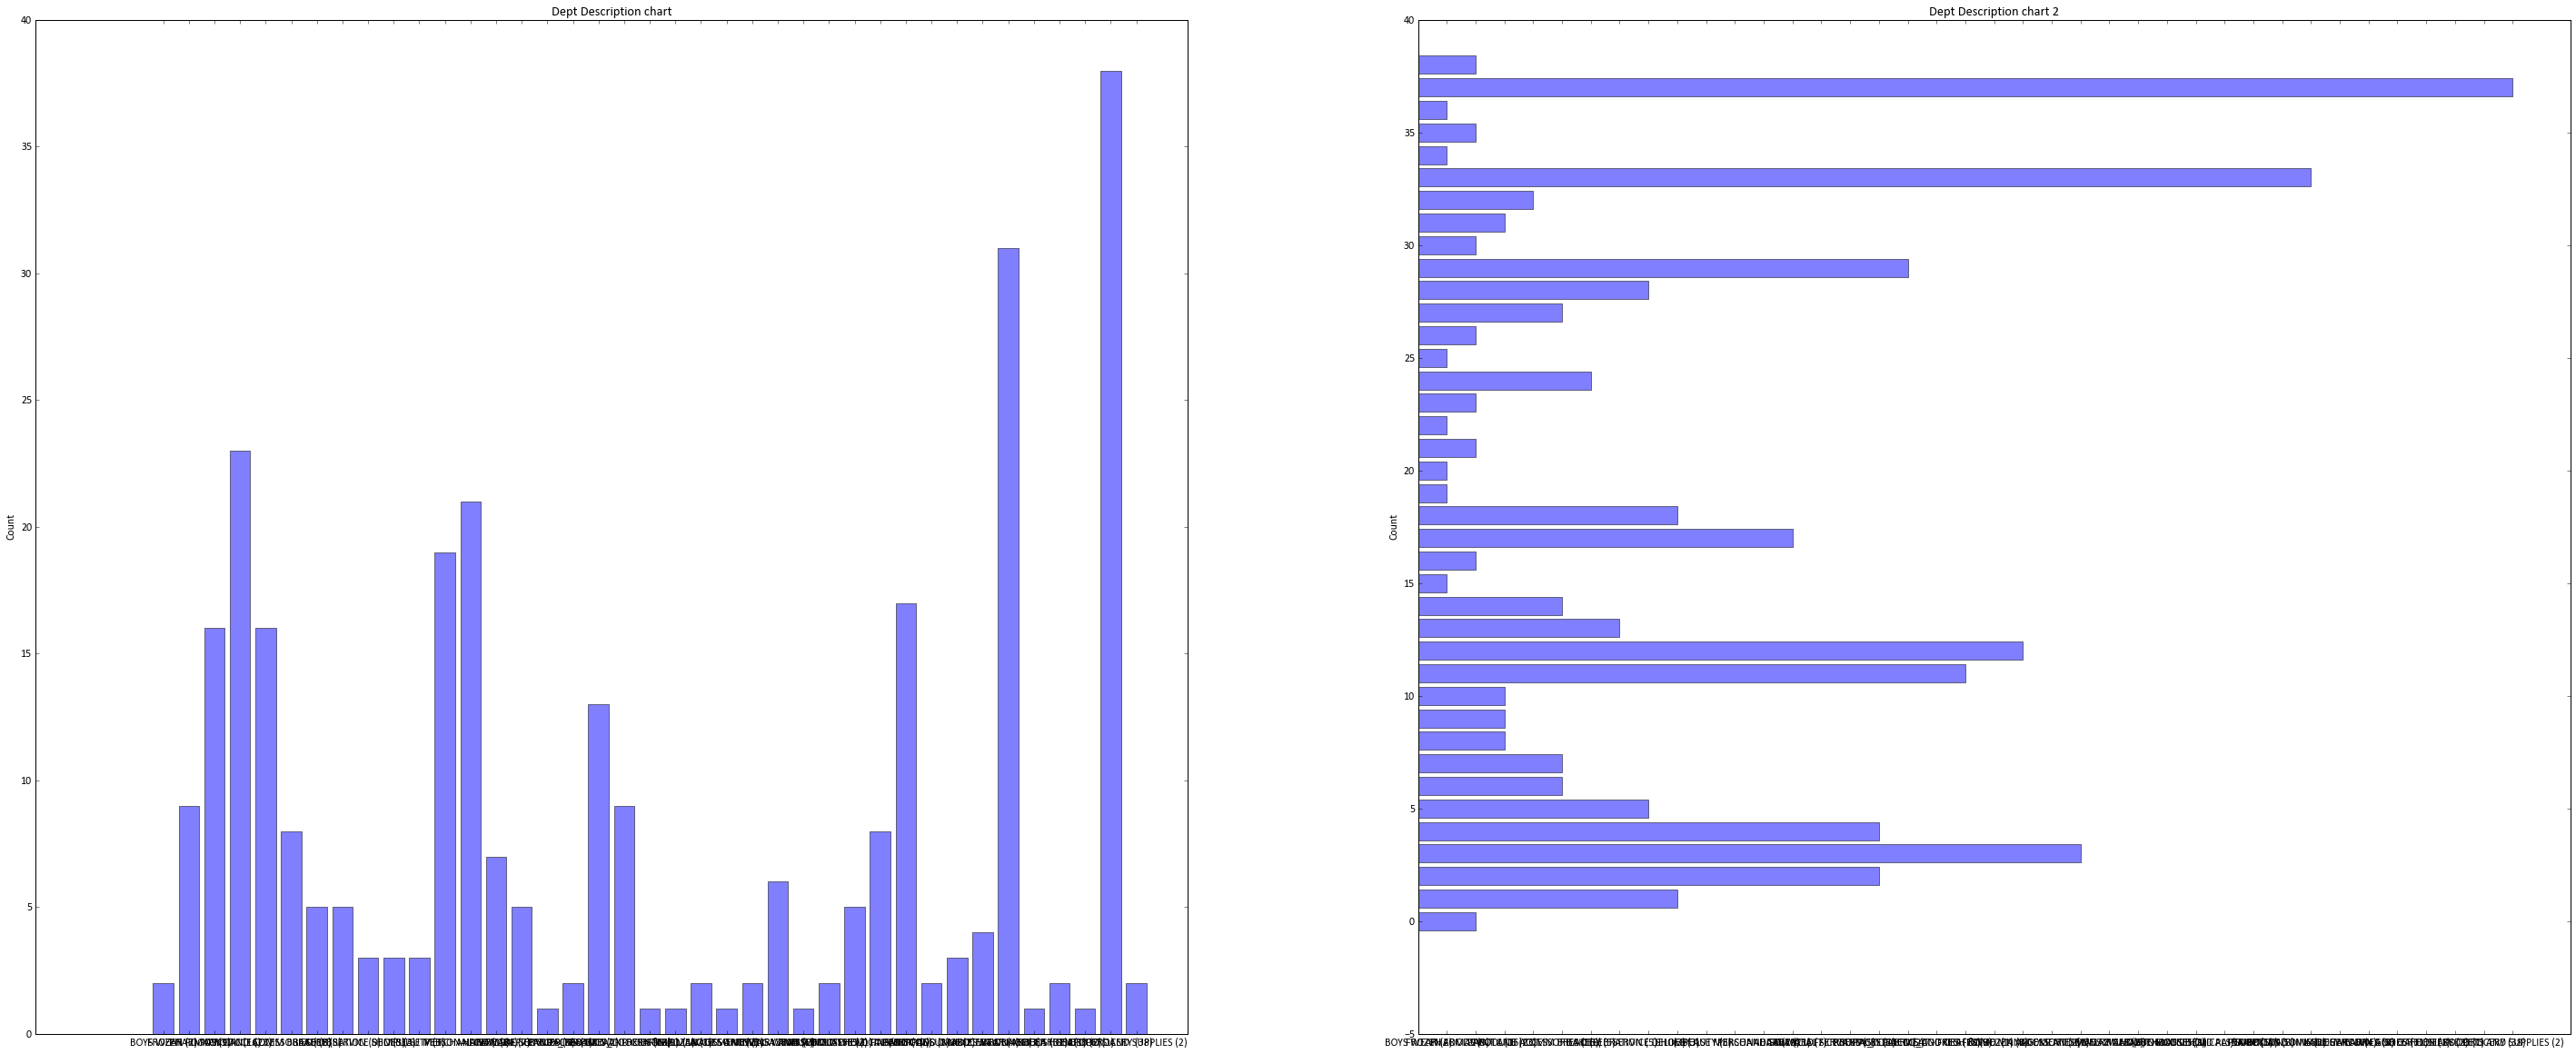

In [62]:
plt.rcParams.update({'font.size': 12})

# fig = plt.figure()
# ax = fig.add_subplot(111)

# specifies the parameters of our graphs
fig = plt.figure(figsize=(50,20), dpi=1600) 
# alpha=alpha_scatterplot = 0.2 
# alpha_bar_chart = 0.55
ax = plt.subplot2grid((1,2),(0,0))

y_pos = np.arange(len(dept_name))
# performance = [10,8,6,4,2,1]


plt.bar(y_pos, dept_count, align='center', alpha=0.5)
plt.xticks(y_pos, dept_name)
plt.ylabel('Count')
plt.title('Dept Description chart')
 
# plt.show()

plt.subplot2grid((1,2),(0,1))


y_pos = np.arange(len(dept_name))
 
plt.barh(y_pos, dept_count, align='center', alpha=0.5)
plt.xticks(y_pos, dept_name)
plt.ylabel('Count')
plt.title('Dept Description chart 2')
 
plt.show()

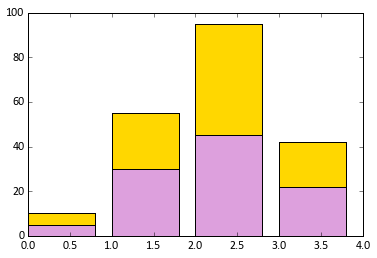

In [121]:
A = [5., 30., 45., 22.]
B = [5., 25., 50., 20.]

X = range(4)
colors = ['yellowgreen', 'plum', 'gold', 'lightskyblue', 'lightcoral']
plt.bar(X, A, color = 'plum')
plt.bar(X, B, color = 'gold', bottom = A)
plt.show()

In [64]:
col_dept_count = df.select('DepartmentDescription').distinct().count()

In [65]:
col_dept_count

39

In [15]:
#data_label = df.map(lambda line:LabeledPoint(float(line[3]),[line[1], line[1], line[2], line[4], line[5], line[6]]))
data_label = df.map(lambda line:LabeledPoint(float(line[3]),[line[0],line[1]]))
data_label.take(5)

[LabeledPoint(999.0, [1000.0]),
 LabeledPoint(30.0, [8931.0]),
 LabeledPoint(30.0, [4504.0]),
 LabeledPoint(26.0, [3565.0]),
 LabeledPoint(26.0, [1017.0])]

In [16]:
data_label = df.map(lambda line:LabeledPoint(float(line[3]),[line[0],line[1]]))

In [66]:
import h2o

In [26]:
h2o.init()



No instance found at ip and port: localhost:54321. Trying to start local jar...


JVM stdout: c:\users\nguyen\appdata\local\temp\tmpumevqe\h2o_nguyen_started_from_python.out
JVM stderr: c:\users\nguyen\appdata\local\temp\tmpx9e5gu\h2o_nguyen_started_from_python.err
Using ice_root: c:\users\nguyen\appdata\local\temp\tmpqoyls2


Java Version: java version "1.8.0_20"
Java(TM) SE Runtime Environment (build 1.8.0_20-b26)
Java HotSpot(TM) 64-Bit Server VM (build 25.20-b23, mixed mode)


Starting H2O JVM and connecting: . Connection successful!


H2O cluster uptime:,2 seconds 649 milliseconds
H2O cluster version:,3.6.0.3
H2O cluster name:,H2O_started_from_python
H2O cluster total nodes:,1
H2O cluster total memory:,1.76 GB
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321


In [67]:
import pysparkling as water

In [68]:
hc = water.H2OContext(sc).start()

H2O cluster uptime:,3 seconds 648 milliseconds
H2O cluster version:,3.6.0.3
H2O cluster name:,sparkling-water-nguyen
H2O cluster total nodes:,1
H2O cluster total memory:,964.5 MB
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54325


In [75]:
hframe = h2o.import_file(("D:\\lectures\\bdpj\docs 2\\kaggle samples\\5_Walmart shopping trip\\train.csv"))


Parse Progress: [##################################################] 100%


In [80]:
hframe.show()

TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
999,5,Friday,6.81132e+10,-1,FINANCIAL SERVICES,1000
30,7,Friday,6.05388e+10,1,SHOES,8931
30,7,Friday,7.41081e+09,1,PERSONAL CARE,4504
26,8,Friday,2.2384e+09,2,PAINT AND ACCESSORIES,3565
26,8,Friday,2.00661e+09,2,PAINT AND ACCESSORIES,1017
26,8,Friday,2.00662e+09,2,PAINT AND ACCESSORIES,1017
26,8,Friday,2.00661e+09,1,PAINT AND ACCESSORIES,1017
26,8,Friday,7.0048e+09,1,PAINT AND ACCESSORIES,2802
26,8,Friday,2.2385e+09,1,PAINT AND ACCESSORIES,4501
26,8,Friday,2.2384e+09,-1,PAINT AND ACCESSORIES,3565


In [71]:
hcol = hframe['VisitNumber']
# hcol = hframe[1]
hcol

VisitNumber
5
7
7
8
8
8
8
8
8
8


In [72]:
hframe = hframe[hcol>7]
hframe

TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
26,8,Friday,2.2384e+09,2,PAINT AND ACCESSORIES,3565
26,8,Friday,2.00661e+09,2,PAINT AND ACCESSORIES,1017
26,8,Friday,2.00662e+09,2,PAINT AND ACCESSORIES,1017
26,8,Friday,2.00661e+09,1,PAINT AND ACCESSORIES,1017
26,8,Friday,7.0048e+09,1,PAINT AND ACCESSORIES,2802
26,8,Friday,2.2385e+09,1,PAINT AND ACCESSORIES,4501
26,8,Friday,2.2384e+09,-1,PAINT AND ACCESSORIES,3565
26,8,Friday,5.20001e+09,1,DSD GROCERY,4606
26,8,Friday,8.86793e+10,2,PAINT AND ACCESSORIES,3504
26,8,Friday,2.2006e+10,1,MEAT - FRESH & FROZEN,6009


In [81]:
hf = hframe ##back to hf that stores data converted from df, an rdd

In [19]:
#print(h2o.import_frame("/home/ubuntu/hd/sparkling-water-1.5.6/water_data/sample_walmart.csv"))

In [20]:
# Publish Spark DataFrame as H2OFrame with given name
hf = hc.as_h2o_frame(df, "hf_from_df")

In [82]:
hf

TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
999,5,Friday,6.81132e+10,-1,FINANCIAL SERVICES,1000
30,7,Friday,6.05388e+10,1,SHOES,8931
30,7,Friday,7.41081e+09,1,PERSONAL CARE,4504
26,8,Friday,2.2384e+09,2,PAINT AND ACCESSORIES,3565
26,8,Friday,2.00661e+09,2,PAINT AND ACCESSORIES,1017
26,8,Friday,2.00662e+09,2,PAINT AND ACCESSORIES,1017
26,8,Friday,2.00661e+09,1,PAINT AND ACCESSORIES,1017
26,8,Friday,7.0048e+09,1,PAINT AND ACCESSORIES,2802
26,8,Friday,2.2385e+09,1,PAINT AND ACCESSORIES,4501
26,8,Friday,2.2384e+09,-1,PAINT AND ACCESSORIES,3565


In [83]:
hf["DepartmentDescription"] = hf["DepartmentDescription"].asfactor()
hf["Weekday"] = hf["Weekday"].asfactor()
hf["TripType"] = hf["TripType"].asfactor()

In [84]:
# Split final data table
ratios = [0.7]
hfs = hf.split_frame(ratios)
train = hfs[0]
test = hfs[1]

In [25]:
#train_data,test_data = df.randomSplit([0.7, 0.3])
#train_data.show(1)

In [15]:
train

TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
30,7,Friday,6.05388e+10,1,SHOES,8931
30,7,Friday,7.41081e+09,1,PERSONAL CARE,4504
26,8,Friday,2.2384e+09,2,PAINT AND ACCESSORIES,3565
26,8,Friday,2.00661e+09,2,PAINT AND ACCESSORIES,1017
26,8,Friday,7.0048e+09,1,PAINT AND ACCESSORIES,2802
26,8,Friday,2.2385e+09,1,PAINT AND ACCESSORIES,4501
26,8,Friday,2.2384e+09,-1,PAINT AND ACCESSORIES,3565
26,8,Friday,5.20001e+09,1,DSD GROCERY,4606
26,8,Friday,8.86793e+10,2,PAINT AND ACCESSORIES,3504
26,8,Friday,2.2006e+10,1,MEAT - FRESH & FROZEN,6009


In [16]:
test

TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
999,5,Friday,6.81132e+10,-1,FINANCIAL SERVICES,1000
26,8,Friday,2.00662e+09,2,PAINT AND ACCESSORIES,1017
26,8,Friday,2.00661e+09,1,PAINT AND ACCESSORIES,1017
26,8,Friday,2.31001e+09,1,PETS AND SUPPLIES,3300
26,8,Friday,7.8742e+09,1,HOUSEHOLD CHEMICALS/SUPP,707
26,8,Friday,5.1142e+09,1,PAINT AND ACCESSORIES,4415
26,8,Friday,3.27001e+09,3,PETS AND SUPPLIES,1001
26,8,Friday,nan,1,NULL,nan
8,9,Friday,1.07008e+09,1,IMPULSE MERCHANDISE,115
35,11,Friday,7.8e+09,1,DSD GROCERY,3467


In [86]:
h2o.kmeans?

In [92]:
deeplearning_model = h2o.deeplearning(x = train.drop("TripType"),
              y            = train["TripType"],
              validation_x = test.drop("TripType"),
              validation_y = test["TripType"],
             )


deeplearning Model Build Progress: [##################################################] 100%


C:\Anaconda23_32\lib\site-packages\IPython\kernel\__main__.py:4: DeprecationWarning: `h2o.deeplearning` is deprecated. Use the estimators sub module to build an H2ODeepLearningEstimator.


In [93]:
deeplearning_model.model_performance(test)


ModelMetricsMultinomial: deeplearning
** Reported on test data. **

MSE: 0.661407792005
R^2: 0.99379077569
LogLoss: 2.24169986276

Confusion Matrix: vertical: actual; across: predicted



3,4,5,6,7,8,9,12,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,999,Error,Rate
1793.0,0.0,10.0,6.0,4.0,2.0,2.0,0.0,0.0,4.0,0.0,1.0,6.0,3.0,1.0,0.0,11.0,16.0,0.0,3.0,1.0,3.0,7.0,0.0,3.0,0.0,2.0,0.0,7.0,0.0,0.0,17.0,110.0,0.0,2.0,0.0,0.0,22.0,0.1,"243 / 2,036"
1.0,0.0,42.0,0.0,4.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,5.0,1.0,0.0,110.0,98.0,0.0,0.0,0.0,0.0,3.0,1.0,274 / 274
16.0,6.0,1433.0,7.0,14.0,24.0,3.0,0.0,0.0,23.0,3.0,1.0,8.0,22.0,7.0,0.0,47.0,54.0,7.0,21.0,4.0,7.0,25.0,2.0,8.0,0.0,4.0,0.0,94.0,22.0,0.0,879.0,1439.0,0.0,12.0,0.0,0.0,28.0,0.7,"2,787 / 4,220"
3.0,0.0,4.0,332.0,15.0,9.0,3.0,0.0,0.0,9.0,0.0,0.0,0.0,7.0,1.0,0.0,5.0,6.0,0.0,5.0,2.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,7.0,12.0,0.0,50.0,524.0,0.0,6.0,0.0,0.0,12.0,0.7,"684 / 1,016"
23.0,0.0,13.0,13.0,953.0,33.0,0.0,0.0,0.0,17.0,4.0,1.0,8.0,11.0,2.0,0.0,28.0,34.0,6.0,16.0,4.0,4.0,16.0,1.0,13.0,0.0,3.0,0.0,23.0,238.0,0.0,152.0,5245.0,0.0,8.0,0.0,1.0,49.0,0.9,"5,966 / 6,919"
---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---
31.0,0.0,42.0,7.0,30.0,35.0,55.0,0.0,0.0,333.0,141.0,22.0,75.0,239.0,44.0,0.0,427.0,864.0,71.0,184.0,49.0,96.0,246.0,21.0,310.0,0.0,13.0,0.0,106.0,30.0,0.0,238.0,1861.0,0.0,206.0,0.0,1.0,94.0,1.0,"5,665 / 5,871"
19.0,0.0,28.0,1.0,21.0,20.0,5.0,0.0,0.0,76.0,20.0,0.0,28.0,80.0,4.0,0.0,116.0,148.0,19.0,46.0,16.0,14.0,41.0,1.0,43.0,0.0,7.0,0.0,71.0,7.0,0.0,132.0,948.0,0.0,55.0,0.0,0.0,27.0,1.0,"1,993 / 1,993"
24.0,0.0,50.0,29.0,38.0,24.0,27.0,0.0,0.0,186.0,42.0,16.0,47.0,155.0,21.0,0.0,354.0,635.0,42.0,178.0,27.0,40.0,158.0,4.0,207.0,0.0,53.0,2.0,201.0,40.0,0.0,230.0,3046.0,0.0,134.0,0.0,1.0,66.0,1.0,"6,076 / 6,077"
378.0,0.0,39.0,7.0,23.0,3.0,19.0,0.0,0.0,30.0,13.0,11.0,12.0,26.0,76.0,2.0,124.0,166.0,16.0,22.0,22.0,13.0,35.0,31.0,24.0,0.0,10.0,0.0,41.0,23.0,0.0,83.0,930.0,0.0,24.0,0.0,0.0,3083.0,0.4,"2,203 / 5,286"



Top-10 Hit Ratios:


k,hit_ratio
1,0.4
2,0.5330382
3,0.650888
4,0.7
5,0.7708431
6,0.8
7,0.8329413
8,0.9
9,0.8669495
10,0.8804475


In [123]:
nb_model = h2o.naive_bayes(x = train.drop("TripType"),
              y            = train["TripType"],
              validation_x = test.drop("TripType"),
              validation_y = test["TripType"],
             )


naivebayes Model Build Progress: [##################################################] 100%


C:\Anaconda23_32\lib\site-packages\IPython\kernel\__main__.py:4: DeprecationWarning: `h2o.naive_bayes` is deprecated. Use the estimators sub module to build an H2ONaiveBayesEstimator.


In [124]:
nb_model.model_performance(test)


ModelMetricsMultinomial: naivebayes
** Reported on test data. **

MSE: 0.762331740184
R^2: 0.992843312658
LogLoss: 2.9703419571

Confusion Matrix: vertical: actual; across: predicted



3,4,5,6,7,8,9,12,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,999,Error,Rate
146.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,1.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0,206.0,1634.0,0.0,0.0,0.0,0.0,18.0,0.9,"1,890 / 2,036"
1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,5.0,258.0,0.0,0.0,0.0,0.0,3.0,1.0,274 / 274
12.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,8.0,20.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,60.0,0.0,0.0,82.0,3938.0,0.0,0.0,0.0,0.0,30.0,1.0,"4,220 / 4,220"
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,22.0,948.0,0.0,0.0,0.0,0.0,17.0,1.0,"1,016 / 1,016"
2.0,0.0,0.0,0.0,12.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,2.0,11.0,0.0,63.0,0.0,0.0,1.0,0.0,0.0,0.0,33.0,0.0,11.0,0.0,0.0,162.0,6543.0,0.0,0.0,0.0,0.0,63.0,1.0,"6,907 / 6,919"
---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---
34.0,0.0,0.0,0.0,2.0,0.0,22.0,0.0,5.0,0.0,0.0,0.0,120.0,1.0,1.0,0.0,112.0,231.0,0.0,29.0,0.0,0.0,10.0,0.0,0.0,0.0,17.0,0.0,106.0,0.0,0.0,148.0,4966.0,0.0,0.0,0.0,0.0,67.0,1.0,"5,871 / 5,871"
7.0,0.0,0.0,0.0,1.0,1.0,8.0,0.0,1.0,0.0,0.0,0.0,41.0,1.0,0.0,0.0,30.0,40.0,0.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,54.0,0.0,0.0,29.0,1743.0,0.0,1.0,0.0,0.0,21.0,1.0,"1,993 / 1,993"
24.0,0.0,0.0,0.0,1.0,7.0,14.0,0.0,6.0,0.0,0.0,0.0,61.0,0.0,0.0,0.0,88.0,152.0,0.0,36.0,0.0,0.0,5.0,0.0,0.0,0.0,21.0,0.0,181.0,0.0,0.0,116.0,5319.0,0.0,0.0,0.0,0.0,46.0,1.0,"6,077 / 6,077"
41.0,0.0,0.0,0.0,2.0,3.0,3.0,0.0,24.0,0.0,0.0,0.0,25.0,1.0,16.0,0.0,17.0,71.0,0.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,60.0,0.0,0.0,102.0,1982.0,0.0,0.0,0.0,0.0,2910.0,0.4,"2,376 / 5,286"



Top-10 Hit Ratios:


k,hit_ratio
1,0.3
2,0.4
3,0.5
4,0.5488426
5,0.5995067
6,0.6370339
7,0.7
8,0.7
9,0.7
10,0.7493782
